In [110]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running the model for prediction tasks


Here we demonstrate model initialization for a model that will ultimately use data only at enrollment for prediction tasks. We initialize the model as in for retrospective tasks, but we modify the Censoring matrix E such that an individual's event times are capped at the minimum of event time or age of recruitment, whicever comes first.


In [111]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96024/432458031.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [112]:
from clust_huge_amp import *
# Subset the data
#Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=20000, end_index=30000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [113]:
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96024/3625861070.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/

In [114]:
import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)

407878

You can see that we take the event times and cap them at the enrollment time or the age of event, whichever occurs first, so if someone has an event prior to enrollment that age (index) is preserved but there is no `leakage of inofrmaiton from the future

In [115]:
# Create enrollment-time-aware E matrix
E_enrollment = E_100k.clone()  # Start with the original censoring times

# For each patient, cap event/censoring times at their enrollment time
pce_df_subset = fh_processed.iloc[20000:30000].reset_index(drop=True)
#pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
for patient_idx, row in enumerate(pce_df_subset.itertuples()):
    if patient_idx >= E_enrollment.shape[0]:  # Make sure we don't go out of bounds
        break
        
    # Calculate enrollment time (age at enrollment - 30)
    enroll_time = int(row.age - 30)
    
    if enroll_time >= 0:  # Make sure enrollment time is valid
        # Cap all disease times to be at most the enrollment time
        # This is the key step: min(original_event_time, enrollment_time)
        E_enrollment[patient_idx, :] = torch.minimum(
            E_enrollment[patient_idx, :], 
            torch.full_like(E_enrollment[patient_idx, :], enroll_time)
        )

In [116]:
for person_idx in range(E_100k.shape[0]):
    enroll_time = int(pce_df_subset.iloc[person_idx]['age'] - 30)
    for disease_idx in range(E_100k.shape[1]):
        event_time = E_100k[person_idx, disease_idx].item()
        if event_time < enroll_time:
            capped_time = E_enrollment[person_idx, disease_idx].item()
            print(f"Person {person_idx}, Disease {disease_idx}:")
            print(f"  Event time: {event_time}")
            print(f"  Enrollment time: {enroll_time}")
            print(f"  Capped time: {capped_time}")
            if capped_time != event_time:
                print("  WARNING: Event time before enrollment was incorrectly capped!")
            else:
                print("  OK: Event time before enrollment is unchanged.")
            break  # Stop after first found
    else:
        continue
    break  # Stop after first found

Person 0, Disease 294:
  Event time: 20
  Enrollment time: 24
  Capped time: 20
  OK: Event time before enrollment is unchanged.


In [122]:

G_with_sex = np.column_stack([G_100k, sex])  # sex should be numeric (e.g., 0/1)
# N

In [123]:
G_with_sex.shape

(10000, 37)

In [124]:


model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_with_sex.shape[1],
    init_sd_scaler=1e-1,
    G=G_with_sex, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters


import cProfile
import pstats
from pstats import SortKey

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')

model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 12 diseases
Cluster 1: 29 diseases
Cluster 2: 11 diseases
Cluster 3: 12 diseases
Cluster 4: 16 diseases
Cluster 5: 7 diseases
Cluster 6: 10 diseases
Cluster 7: 6 diseases
Cluster 8: 96 diseases
Cluster 9: 14 diseases
Cluster 10: 8 diseases
Cluster 11: 7 diseases
Cluster 12: 16 diseases
Cluster 13: 36 diseases
Cluster 14: 6 diseases
Cluster 15: 8 diseases
Cluster 16: 11 diseases
Cluster 17: 27 diseases
Cluster 18: 11 diseases
Cluster 19: 5 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 12
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4783, -0.4783, -0.4783, -0.4783, -0.4783])
Base value centered mean: -1.1146545375595451e-06
Gamma init for k=0 (first 5): tensor([-0.0026, -0.0013, -0.0065,  0.0002, -0.0136])

Calculating gamma for k=1:
Number of diseases in cluster: 29
Base value (first 5): tensor([-12.7931, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96024/3075431586.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/


Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.3805, -0.3805, -0.3805, -0.3805, -0.3805])
Base value centered mean: -1.216125497194298e-06
Gamma init for k=2 (first 5): tensor([-0.0004,  0.0047, -0.0032, -0.0015, -0.0113])

Calculating gamma for k=3:
Number of diseases in cluster: 82.0
Base value (first 5): tensor([-13.6950, -13.6950, -13.8155, -13.8155, -13.6950])
Base value centered (first 5): tensor([ 0.0189,  0.0189, -0.1016, -0.1016,  0.0189])
Base value centered mean: -8.369445936295961e-07
Gamma init for k=3 (first 5): tensor([-0.0006, -0.0010, -0.0023,  0.0020,  0.0022])

Calculating gamma for k=4:
Number of diseases in cluster: 5.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1214, -0.1214, -0.1214, -0.1214, -0.1214])
Base value centered mean: -2.5482177079538815

In [125]:
print(model.G.shape)
print(model.gamma.shape)

torch.Size([10000, 37])
torch.Size([37, 21])


Fit the model

In [59]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()

history_new = model.fit(E_enrollment, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 16.9486

Monitoring signature responses:

Disease 161 (signature 7, LR=32.01):
  Theta for diagnosed: 0.150 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.74):
  Theta for diagnosed: 0.151 ± 0.039
  Theta for others: 0.148
  Proportion difference: 0.004

Disease 260 (signature 8, LR=30.42):
  Theta for diagnosed: 0.098 ± 0.083
  Theta for others: 0.087
  Proportion difference: 0.011

Disease 347 (signature 3, LR=29.39):
  Theta for diagnosed: 0.148 ± 0.071
  Theta for others: 0.150
  Proportion difference: -0.002

Disease 50 (signature 15, LR=28.86):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002

Epoch 1
Loss: 663.8109

Monitoring signature responses:

Disease 161 (signature 7, LR=32.00):
  Theta for diagnosed: 0.150 ± 0.036
  Theta for others: 0.148
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.76):
  Theta for diagnosed: 0.152 ± 0.037
  Theta for others: 0

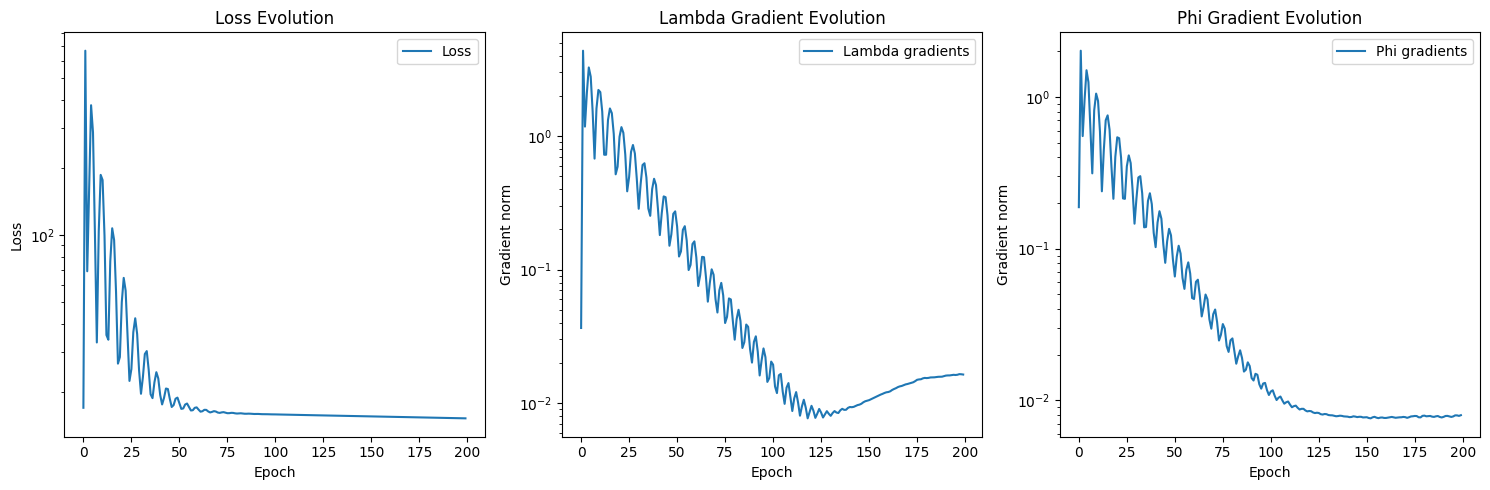

In [60]:
from utils import *
plot_training_evolution(history_new)

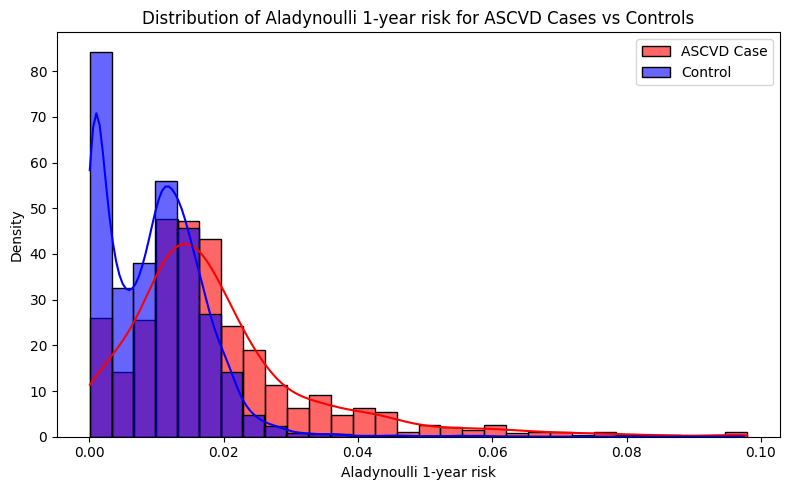

In [131]:
# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)



Y_test = model.Y
test_start=20000
test_end=30000
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_test.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

import numpy as np
import torch
ascvd_indices=[111,112,113,114,115,116]
cases = []
controls = []
for i in range(len(FH_test)):
    age = FH_test.iloc[i]['age']
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_test.shape[2]:
        continue
    end_time = min(t_enroll + 10, Y_test.shape[2])
    had_event = 0
    for d_idx in ascvd_indices:
        if torch.any(Y_test[i, d_idx, t_enroll:end_time] > 0):
            had_event = 1
            break
    if had_event:
        cases.append(aladynoulli_1yr_risk_test[i])
    else:
        controls.append(aladynoulli_1yr_risk_test[i])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cases, color='red', label='ASCVD Case', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(controls, color='blue', label='Control', kde=True, stat='density', bins=30, alpha=0.6)
plt.xlabel('Aladynoulli 1-year risk')
plt.ylabel('Density')
plt.title('Distribution of Aladynoulli 1-year risk for ASCVD Cases vs Controls')
plt.legend()
plt.tight_layout()
plt.show()

In [109]:

# Save model
W=0.0001
torch.save({
    'model_state_dict': model.state_dict(),
    'E':E_enrollment,
    'phi': model.phi,
    'Y': model.Y,
    'prevalence_t': model.prevalence_t,
    'logit_prevalence_t': model.logit_prev_t,
    'G': model.G,
}, f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W{W}_jointphi_sexspecific_20000_30000.pt')

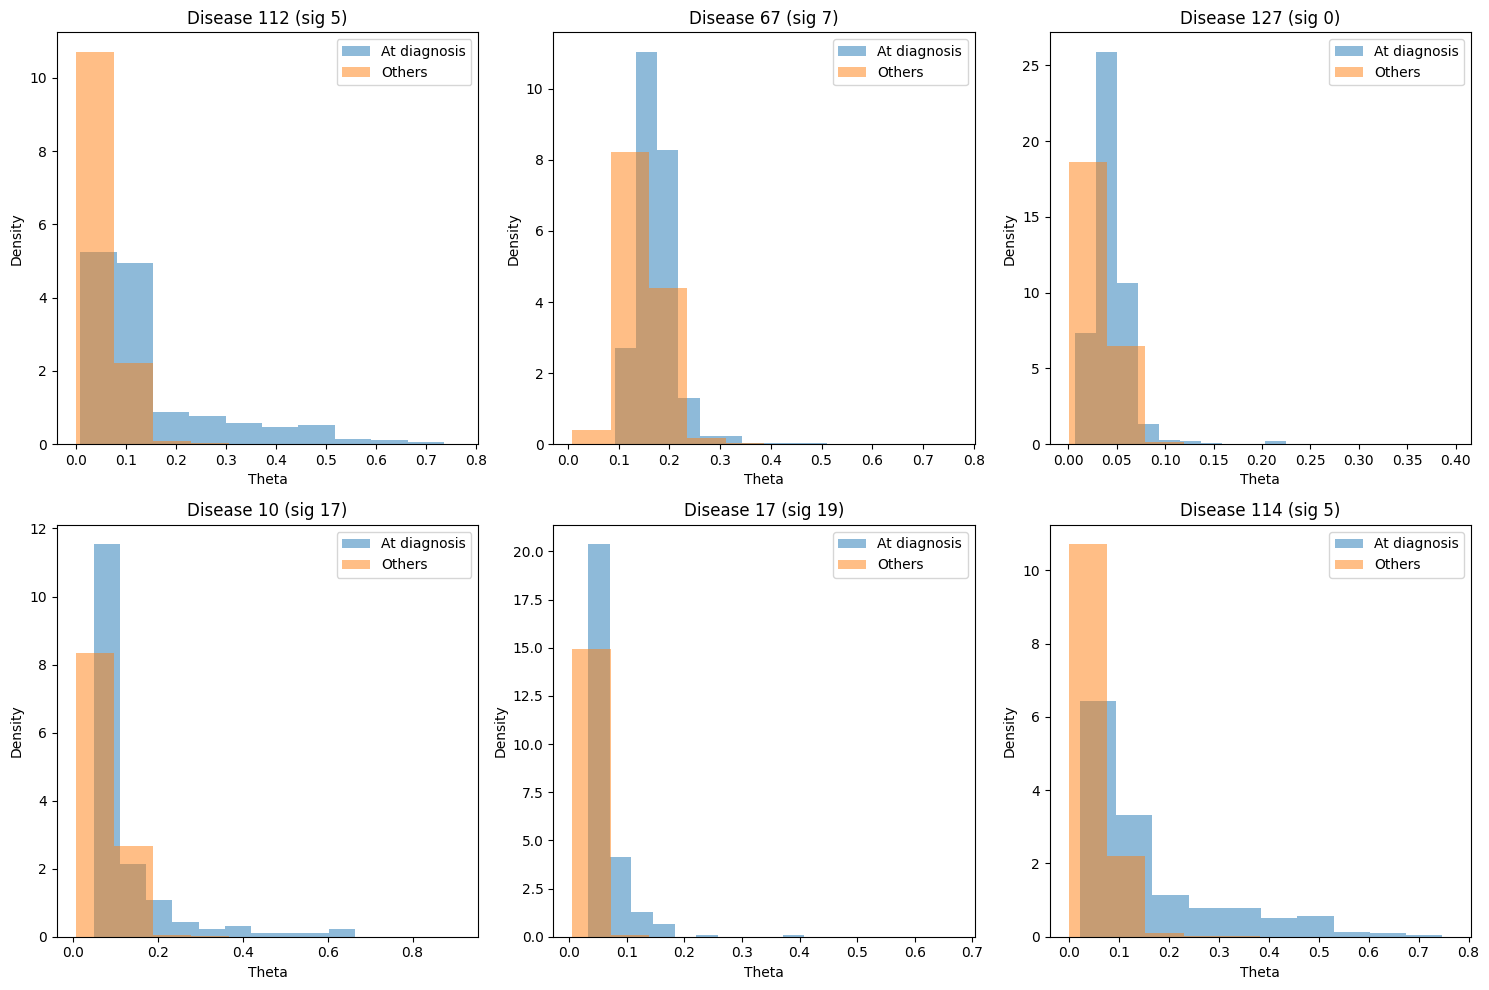

In [135]:

plot_theta_differences(model, diseases=[112,67,127,10,17,114], signatures=[5,7,0,17,19,5])